# Bone marrow lymphoid T and NK cells acute (4h) response to LPS-SI
Author: Farid Keramati  
Date: 01/10/2022

Use the following code to characterize the acute (4h) response of bone marrow-resident lymphoid T lineage and NK cells to LPS-induced systemic inflammation.  
To run the following code, we will use the Seurat object generated in the [first analysis script](https://github.com/fkeramati/LPS-SI/blob/main/Analysis%20Scripts/All%20Bone%20Marrow%20Mononuclear%20Cell%20from%20All%20Time%20Points.ipynb).<br></br> 
First, we will subset day 0 and 4 hours samples and then will subset lymphoid T and NK cells.

### Load required packages

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))

### Read in previously generated Seurat object and subset T and NK cells

In [2]:
bm = readRDS("./Bonemarrow_allCells_allTimePoints_MNN_batchCorrected.rds")
bm = subset(bm, subset = TimePoint == "D7", invert = T)
lympho_tmp = subset(bm, idents = c("CD8 Naive", "CD4 Naive", "Inflam T", "CD4 Memory", "CD8 Memory", "NK"))

counts = GetAssayData(lympho_tmp, slot = "counts")
lymphT = CreateSeuratObject(counts = counts, project = "Lympho_T", min.cells = 0, min.features = 0)
rm(lympho_tmp, counts)

### Normalize, scale and perform dimentionality reduction

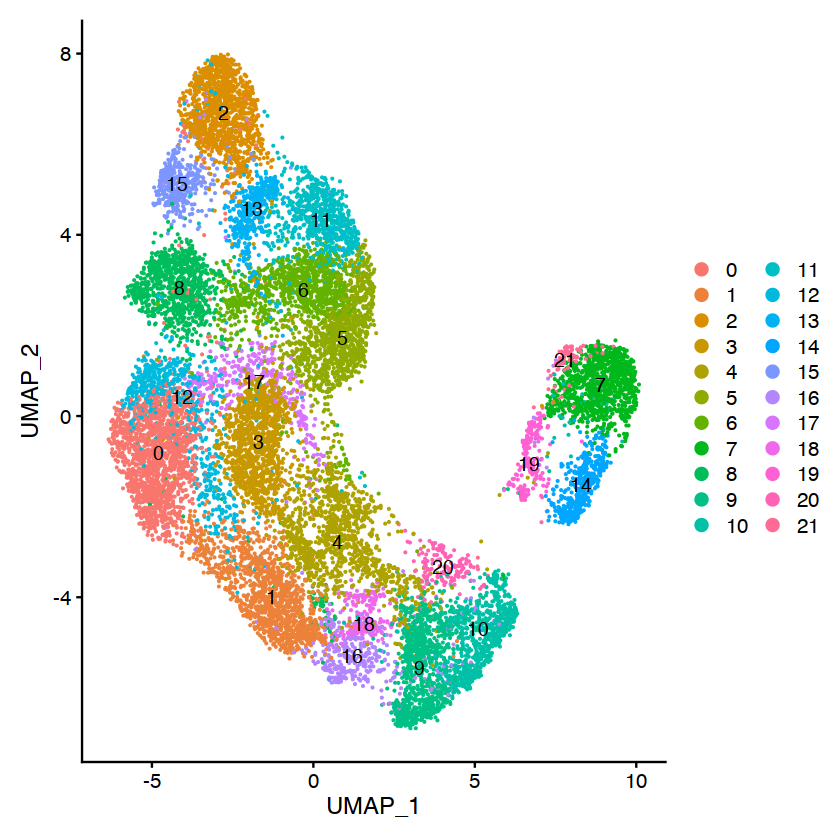

In [3]:
# Normalize and Scale
lymphT = NormalizeData(lymphT, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
lymphT = FindVariableFeatures(lymphT, selection.method = "vst", nfeatures = 3000, verbose = F)
s.genes = cc.genes.updated.2019$s.genes
g2m.genes = cc.genes.updated.2019$g2m.genes
lymphT = CellCycleScoring(lymphT, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)
lymphT$CC.Difference = lymphT$S.Score - lymphT$G2M.Score
lymphT = ScaleData(lymphT, verbose = F)

# PCA, UMAP visualization and clustering
lymphT = RunPCA(lymphT, verbose = F)
lymphT = RunUMAP(lymphT, dims = 1:12, verbose = F)
lymphT = FindNeighbors(lymphT, dims = 1:12, k.param = 20, verbose = F)
lymphT = FindClusters(lymphT, resolution = 1.5, verbose = F)
lymphT@meta.data$Donor = unlist(strsplit(names(lymphT$orig.ident), split = "_"))[c(T,F,F)]
lymphT@meta.data$TimePoint = unlist(strsplit(names(lymphT$orig.ident), split = "_"))[c(F,T,F)]
DimPlot(lymphT, label = T, pt.size = 0.1)

### Batch correct using MNN and visualize cells

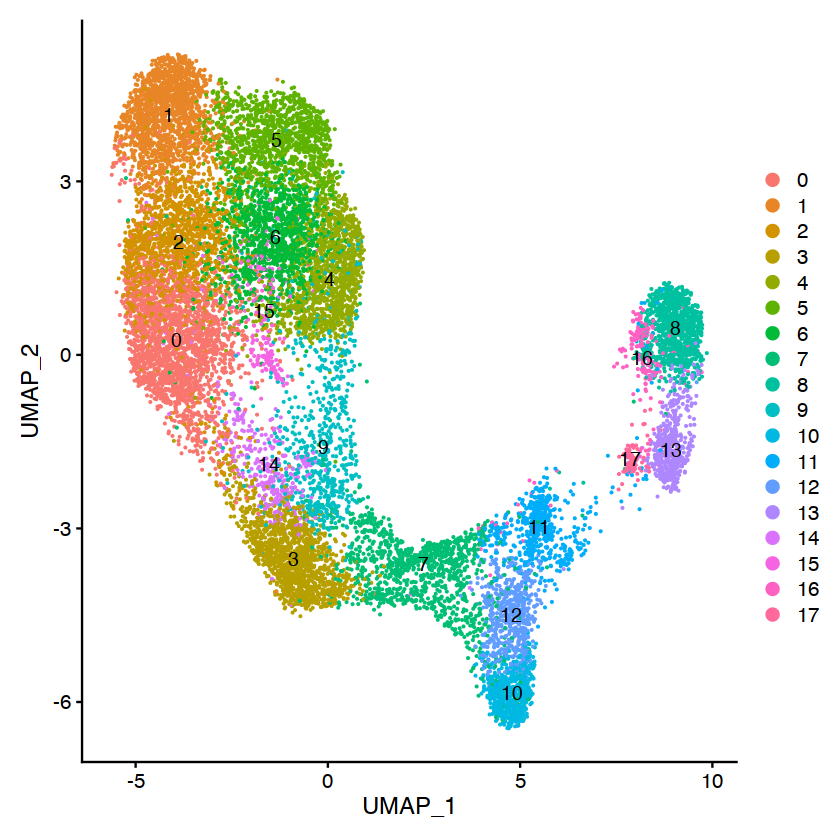

In [4]:
# There is a donor batch effect, correct for it using MNN
lymphT_mnn = RunFastMNN(object.list = SplitObject(lymphT, split.by = "Donor"), features = 2000, verbose = F)
lymphT_mnn = RunUMAP(lymphT_mnn, dims = 1:13, min.dist = 0.2, reduction = "mnn", verbose = F)
lymphT_mnn = FindNeighbors(lymphT_mnn, dims = 1:12, reduction = "mnn", k.param = 20, verbose = F)
lymphT_mnn = FindClusters(lymphT_mnn, resolution = 1.5, verbose = F)
DimPlot(lymphT_mnn, label = T)

### Refine cell clustering and assign cell types to each cluster
Cell type assignment is based on known canonical markers.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1161
Number of edges: 30824

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6477
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 663
Number of edges: 22589

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6048
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 586
Number of edges: 18678

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8241
Number of communities: 2
Elapsed time: 0 seconds


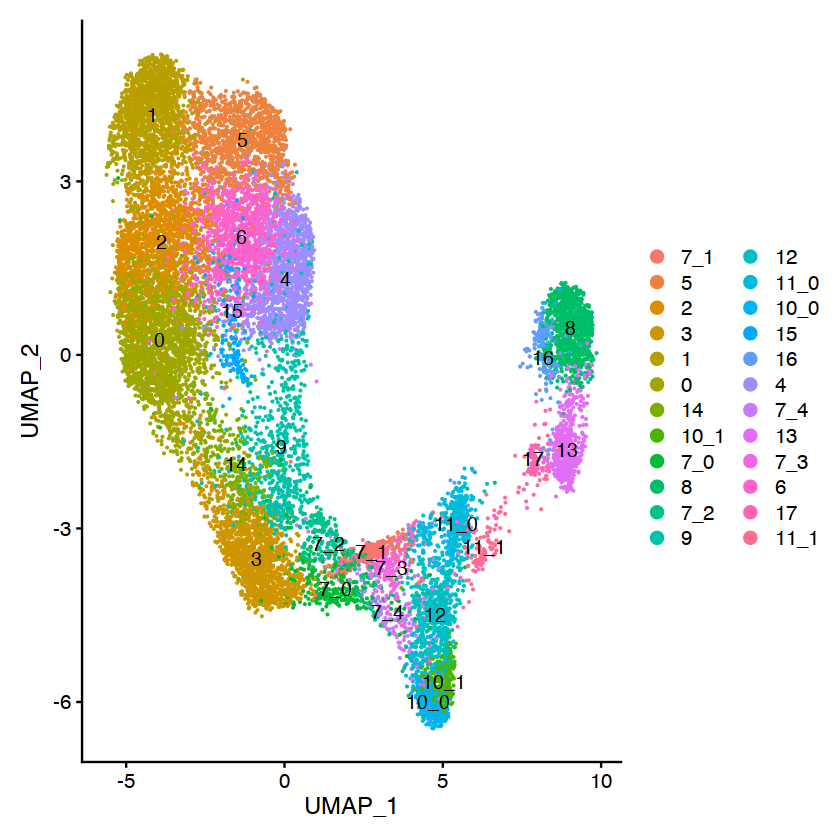

In [5]:
# Further sub-cluster cluster 7
lymphT_mnn = FindSubCluster(lymphT_mnn, cluster = 7, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.7, algorithm = 1)
Idents(lymphT_mnn) = lymphT_mnn$sub.cluster

# Further sub-cluster cluster 10
lymphT_mnn = FindSubCluster(lymphT_mnn, cluster = 10, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.4, algorithm = 1)
Idents(lymphT_mnn) = lymphT_mnn$sub.cluster

# Further sub-cluster cluster 11
lymphT_mnn = FindSubCluster(lymphT_mnn, cluster = 11, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.2, algorithm = 1)
Idents(lymphT_mnn) = lymphT_mnn$sub.cluster

DimPlot(lymphT_mnn, label = T)

In [6]:
# Name clusters
lymphT_mnn = RenameIdents(lymphT_mnn, "0" = "CD4 Naive",  
                         "1" = "CD8 Naive",
                         "2" = "CD4 Naive",
                         "3" = "CD4 Memory", 
                         "4" = "Inflam CD4 Naive",
                         "5" = "Inflam CD8 Naive", 
                         "6" = "Inflam CD4 Naive",
                         "7_0" = "CD4 Memory",
                         "7_1" = "CD8 EM",
                         "7_2" = "Inflam CD4 Memory",
                         "7_3" = "CD8 EM",
                         "7_4" = "CD8 CM",
                         "8" = "NK",
                         "9" = "Inflam CD4 Memory", 
                         "10_0" = "Inflam CD8 CM",
                         "10_1" = "CD8 CM",
                         "11_0" = "CD8 EM", 
                         "11_1" = "Inflam CD8 EM", 
                         "12" = "CD8 CM", 
                         "13" = "Inflam NK", 
                         "14" = "CD4 Memory", 
                         "15" = "CD4 Naive", 
                         "16" = "NK", 
                         "17" = "NK")
lymphT_mnn$CellType = lymphT_mnn@active.ident
lymphT_mnn$CellType = factor(lymphT_mnn$CellType, levels = c("CD8 Naive", "CD4 Naive", "CD4 Memory", "CD8 CM", "CD8 EM",
                                                            "NK", "Inflam CD8 Naive", "Inflam CD4 Naive", "Inflam CD4 Memory",
                                                            "Inflam CD8 CM", "Iflam CD8 EM", "Inflam NK"))

### Visualize cells (colored by cell type)

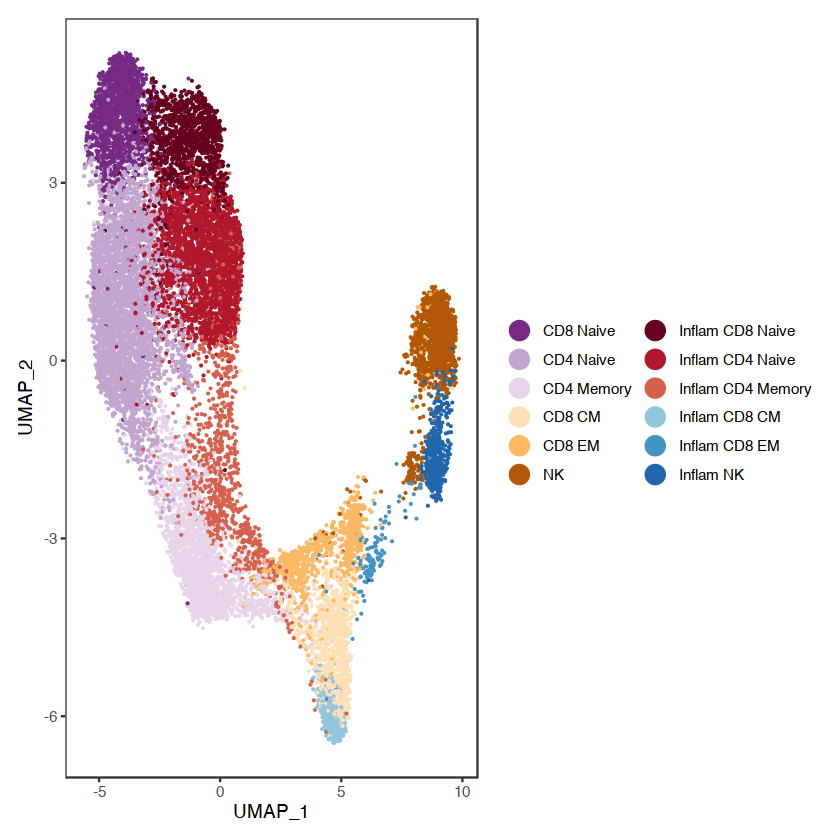

In [7]:
DimPlot(lymphT_mnn, pt.size=0.1) + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
  scale_color_manual(values=c("CD8 Naive"="#762a83",
                              "CD4 Naive"="#c2a5cf",
                              "CD4 Memory"="#e7d4e8",
                              "CD8 CM"="#fee0b6",
                              "CD8 EM"="#fdb863",
                              "NK"="#b35806",
                              "Inflam CD8 Naive"="#67001f",
                              "Inflam CD4 Naive"="#b2182b",
                              "Inflam CD4 Memory"="#d6604d",
                              "Inflam CD8 CM"="#92c5de",
                              "Inflam CD8 EM"="#4393c3",
                              "Inflam NK"="#2166ac")) +
  guides(color=guide_legend(ncol=2, override.aes = list(size=5)))

### Visualize cells (colored by time point)

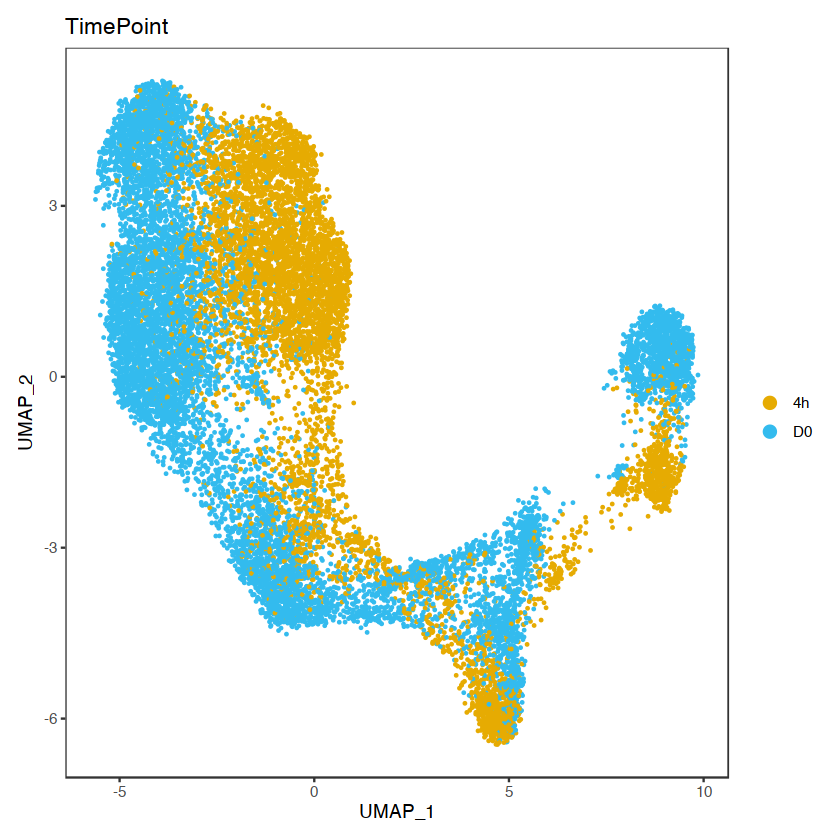

In [8]:
DimPlot(lymphT_mnn, label = F, pt.size = 0.3, group.by = "TimePoint", shuffle = T) + scale_color_manual(values=c("#e6ab02", "#33bbee", "#ee3377")) +
  theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank())

### Save object
You can save **lymphT** object to use it in the future.

In [9]:
saveRDS(lymphT_mnn, "LymphoidT_NK_Day0_4h_MNN_batchCorrected.rds")